In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!cp /content/drive/MyDrive/Dataset/eeg/data_import.py /content
from data_import import data_load 

strt= 160
flen = 320
x_train,y_train,x_test,y_test,x_val,y_val = data_load(strt ,flen)

<class 'function'>


In [15]:
from tensorflow.python.keras.backend import clear_session
import tensorflow as tf,keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pylab as plt
import torch.utils.data as data
#import h5py
#import csv
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
import keras
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, LSTM,Dropout
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from torchvision import transforms

In [16]:
y_train = to_categorical(y_train, num_classes=40)
y_val = to_categorical(y_val, num_classes=40)
y_test = to_categorical(y_test, num_classes=40)

#Transformer


In [17]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)        
        return self.layernorm2(out1 + ffn_output)


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy') >= 0.995):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.995))
			self.model.stop_training = True

In [18]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

sequence_input = tf.keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
transformer_block = TransformerBlock(x_train.shape[2], num_heads, ff_dim)
x = transformer_block(sequence_input)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(40, activation="softmax")(x)
model = tf.keras.Model(inputs=sequence_input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 320, 128)]        0         
_________________________________________________________________
transformer_block (Transform (None, 320, 128)          140832    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 40)                5160      
Total params: 162,504
Trainable params: 162,504
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                   epochs=45, batch_size=32,callbacks = myCallback())
print(model.evaluate(x_test, y_test))

Epoch 1/45
300/300 [==============================] - 16s 39ms/step - loss: 2.0652 - accuracy: 0.4188 - val_loss: 1.0222 - val_accuracy: 0.6775
Epoch 2/45
300/300 [==============================] - 11s 38ms/step - loss: 0.6793 - accuracy: 0.7992 - val_loss: 0.4845 - val_accuracy: 0.8571
Epoch 3/45
300/300 [==============================] - 11s 37ms/step - loss: 0.3508 - accuracy: 0.8998 - val_loss: 0.3037 - val_accuracy: 0.9098
Epoch 4/45
300/300 [==============================] - 11s 37ms/step - loss: 0.2162 - accuracy: 0.9396 - val_loss: 0.2337 - val_accuracy: 0.9282
Epoch 5/45
300/300 [==============================] - 11s 37ms/step - loss: 0.1740 - accuracy: 0.9501 - val_loss: 0.1792 - val_accuracy: 0.9515
Epoch 6/45
300/300 [==============================] - 11s 37ms/step - loss: 0.1094 - accuracy: 0.9700 - val_loss: 0.1554 - val_accuracy: 0.9541
Epoch 7/45
300/300 [==============================] - 11s 38ms/step - loss: 0.1047 - accuracy: 0.9712 - val_loss: 0.1725 - val_accuracy:

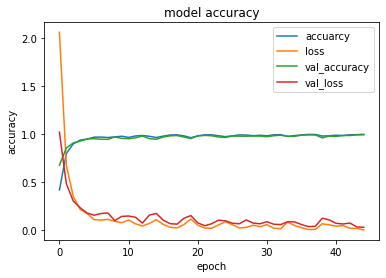

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuarcy', 'loss','val_accuracy','val_loss'], loc='upper right')
plt.show()

In [21]:
# extract = Model(model.inputs, model.layers[-2].output)
# features = extract.predict(x_train)
# extract.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 157,344
Trainable params: 157,344
Non-trainable params: 0
_________________________________________________________________
